In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw,ImageFont
from matplotlib import cm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#classes dictionary
classes_dict={0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}

In [5]:
def load_dataset():
    import csv
    import numpy as np

    file_path = '/content/drive/MyDrive/fer2013.csv'

    with open(file_path, 'r') as f:
        data = csv.reader(f)
        X = []
        Y = []
        i = 1
        for row in data:
            if i:  # Skip the first row (header)
                i = 0
                continue
            try:
                pixels = [int(n) for n in row[1].split(' ')]
                if len(pixels) == 2304:  # Ensure the row has the correct number of elements
                    Y.append(int(row[0]))
                    X.append(pixels)
                else:
                    print(f"Row skipped due to inconsistent length: {len(pixels)}")
            except Exception as e:
                print(f"Error processing row: {e}")

    return (np.array(X), np.array(Y))


In [6]:
# Load dataset
X, Y = load_dataset()

# Normalize pixel values to range [0, 1]
X = X / 255.0

# Reshape data to match image format
X = X.reshape((X.shape[0], 48, 48, 1))  # 48x48 grayscale images
Y = Y.reshape(Y.shape + (1,))

print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: (35887, 48, 48, 1)
Y shape: (35887, 1)


In [7]:
#split the dataset into train and test
from sklearn.model_selection import train_test_split
np.random.seed(0)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.08,random_state=0)

In [8]:
#converting the train and test labels into one-hot encoding
from tensorflow.keras.utils import to_categorical
Y_train_oh=to_categorical(Y_train,len(classes_dict))
Y_test_oh=to_categorical(Y_test,len(classes_dict))

In [9]:
#definition of create_model()
def create_model():
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input,Conv2D,Dense,BatchNormalization,Activation
    from tensorflow.keras.layers import Dropout,MaxPooling2D,AveragePooling2D,Flatten

    inputs=Input(shape=(48,48,1))

    X=Conv2D(filters=32,kernel_size=(7,7),padding='same')(inputs)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((2,2))(X)
    X=Dropout(.25)(X)

    X=Conv2D(filters=64,kernel_size=(3,3),padding='same')(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((2,2))(X)
    X=Dropout(.25)(X)

    X=Conv2D(filters=128,kernel_size=(3,3),padding='same')(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((2,2))(X)
    X=Dropout(.25)(X)

    X=Conv2D(filters=256,kernel_size=(3,3),padding='same')(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=AveragePooling2D((6,6))(X)
    X=Dropout(.25)(X)

    X=Flatten()(X)
    X=Dense(256)(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=Dropout(.25)(X)

    X=Dense(128)(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=Dropout(.25)(X)

    X=Dense(7,'softmax')(X)

    model=Model(inputs=inputs,outputs=X)
    return model


In [10]:
import os
from tensorflow.keras.models import load_model

# Set this to False if you want to train a new model
load_pretrained_model = True

if load_pretrained_model:
    # Path to the uploaded model file
    model_path = '/content/model.h5'  # Update this if the file name or path is different

    if os.path.exists(model_path):
        model = load_model(model_path)
        print('Model is loaded successfully.')
    else:
        print(f'Model file not found at {model_path}. Please upload it to Colab.')

else:
    # Define the function to create your model (not shown in your code, so you'll need to implement it)
    model = create_model()  # Replace this with your actual model creation function

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    num_iterations = 114
    model.fit(X_train, Y_train_oh, batch_size=64, epochs=num_iterations, validation_split=0.08, verbose=2)

    # Save the model
    model.save('/content/model.h5', save_format='h5')
    print('Model is trained and saved successfully.')


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model is loaded successfully.


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6703 - loss: 1.0215
Test Accuracy = 0.6659700274467468


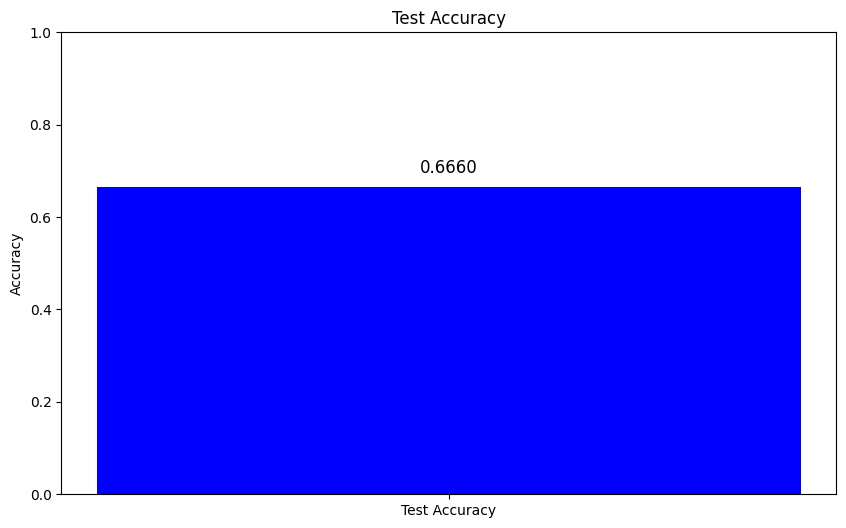

In [11]:
import matplotlib.pyplot as plt

# Evaluate loss and accuracy on the test set
loss, accuracy = model.evaluate(X_test, Y_test_oh)
print('Test Accuracy =', accuracy)

# Plot the test accuracy
plt.figure(figsize=(10, 6))
plt.bar(['Test Accuracy'], [accuracy], color='blue')

# Add accuracy value on the bar
plt.text(0, accuracy + 0.02, f'{accuracy:.4f}', ha='center', va='bottom', fontsize=12, color='black')

# Add title and labels
plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
Prediction 1:
Predicted class: Happy
Actual class:  Happy


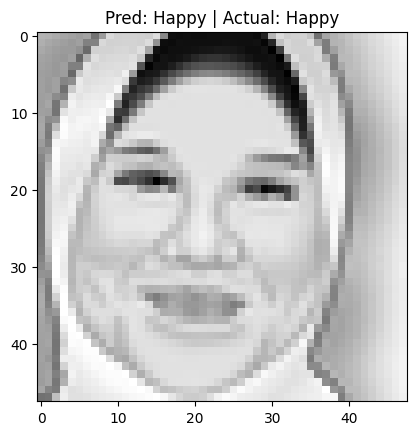

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction 2:
Predicted class: Sad
Actual class:  Sad


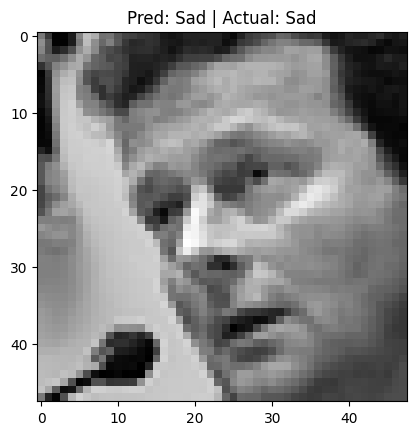

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction 3:
Predicted class: Surprise
Actual class:  Fear


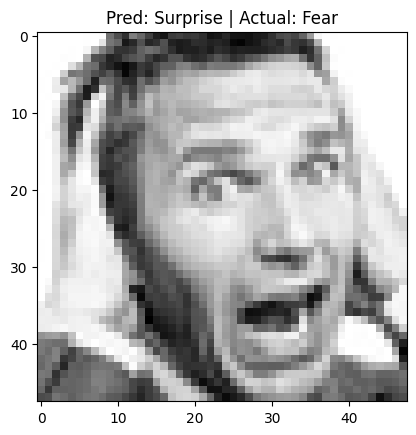

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction 4:
Predicted class: Sad
Actual class:  Sad


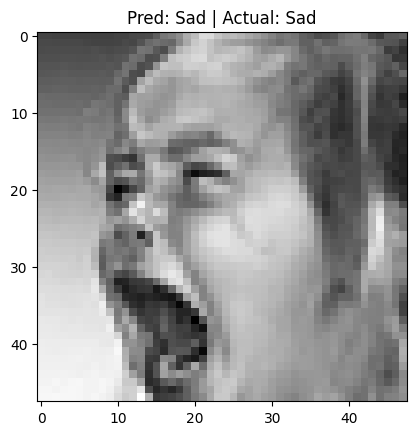

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction 5:
Predicted class: Angry
Actual class:  Angry


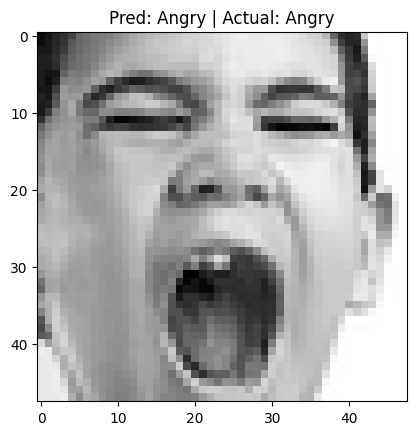

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction 6:
Predicted class: Neutral
Actual class:  Neutral


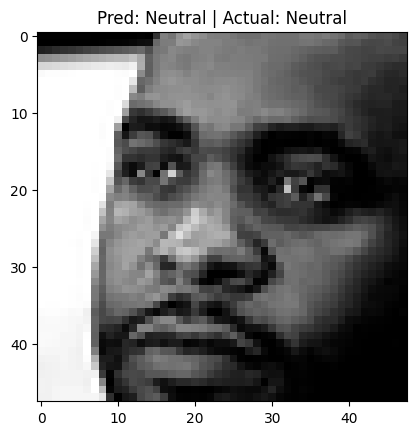

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction 7:
Predicted class: Happy
Actual class:  Happy


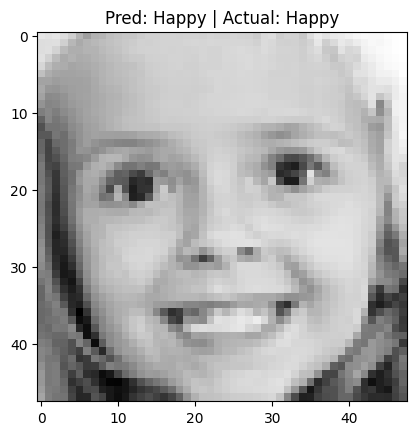

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction 8:
Predicted class: Happy
Actual class:  Neutral


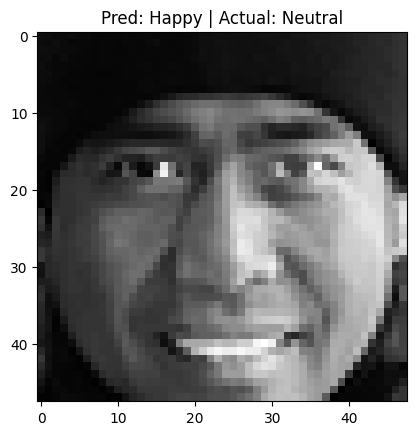

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction 9:
Predicted class: Fear
Actual class:  Fear


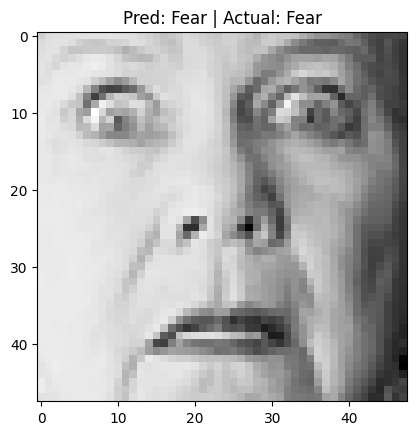

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction 10:
Predicted class: Neutral
Actual class:  Neutral


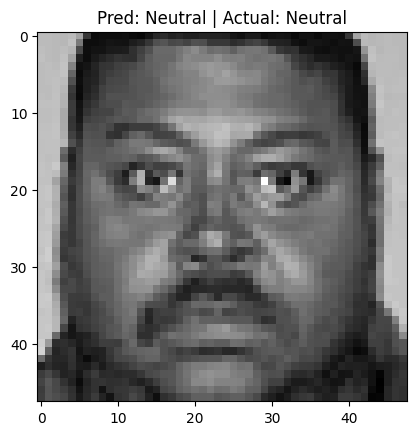

In [12]:
import matplotlib.pyplot as plt

# Number of predictions you want to see (e.g., first 5 images)
num_predictions = 10

# Loop through the images and display predictions
for index in range(num_predictions):
    # Predicted class
    pred_class = np.argmax(model.predict(X_test[index:index+1]), axis=1)
    print(f"Prediction {index + 1}:")
    print('Predicted class:', classes_dict[pred_class[0]])  # Display the predicted class
    print('Actual class: ', classes_dict[Y_test.squeeze()[index]])  # Display the actual class
    plt.imshow(X_test[index].squeeze(), cmap='gray')  # Display the image
    plt.title(f"Pred: {classes_dict[pred_class[0]]} | Actual: {classes_dict[Y_test.squeeze()[index]]}")
    plt.show()


Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 72s 279ms/step - accuracy: 0.8346 - loss: 0.4555 - val_accuracy: 0.6562 - val_loss: 1.1078
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 63s 245ms/step - accuracy: 0.8426 - loss: 0.4530 - val_accuracy: 0.6304 - val_loss: 1.1669
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 82s 245ms/step - accuracy: 0.8335 - loss: 0.4541 - val_accuracy: 0.6468 - val_loss: 1.1613
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 63s 244ms/step - accuracy: 0.8379 - loss: 0.4518 - val_accuracy: 0.6649 - val_loss: 1.0861
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 63s 245ms/step - accuracy: 0.8374 - loss: 0.4435 - val_accuracy: 0.6632 - val_loss: 1.1110
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 64s 247ms/step - accuracy: 0.8414 - loss: 0.4505 - val_accuracy: 0.6597 - val_loss: 1.1251
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 63s 245ms/step - accuracy: 0.8346 - loss: 0.4578 - val_accuracy: 0.6611 - val_loss: 1.1234
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 88s 267ms/step - accuracy: 0.8429 - loss: 0

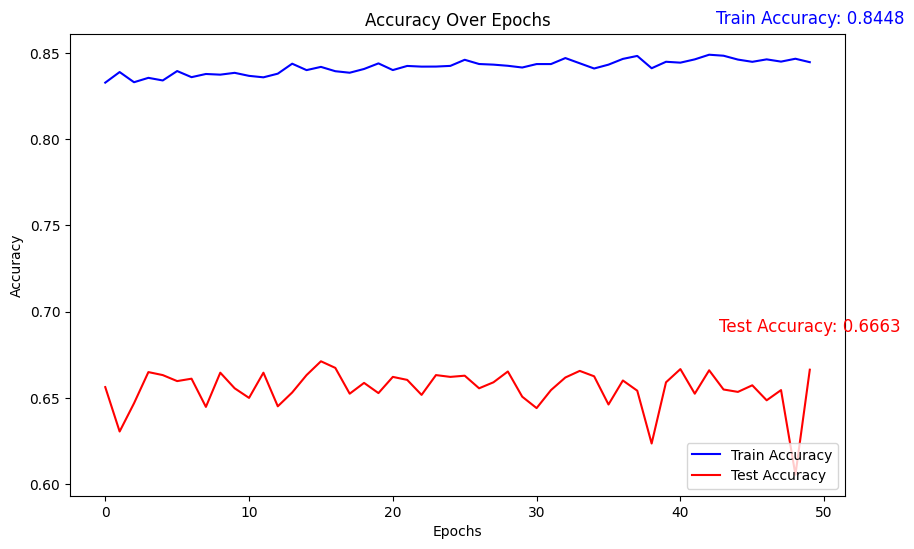

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Enable eager execution
tf.config.run_functions_eagerly(True) # Force eager execution for TensorFlow 2.x

# Assuming you have your data and model defined
# Example: X_train, Y_train_oh, X_test, Y_test_oh

# Recompile the loaded model with a fresh optimizer
# This is crucial to avoid the 'Unknown variable' error
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train_oh, epochs=50, batch_size=128, validation_data=(X_test, Y_test_oh))

# Evaluate the model on the test set to get the final accuracy
loss, test_accuracy = model.evaluate(X_test, Y_test_oh)
print('Test Accuracy =', test_accuracy)
# Plot both training and test accuracy
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')

# Plot test accuracy (validation accuracy)
plt.plot(history.history['val_accuracy'], label='Test Accuracy', color='red')

# Add titles and labels
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Display the accuracy values at the last epoch
plt.text(len(history.history['accuracy']) - 1, history.history['accuracy'][-1] + 0.02,
         f'Train Accuracy: {history.history["accuracy"][-1]:.4f}', ha='center', va='bottom', fontsize=12, color='blue')

plt.text(len(history.history['val_accuracy']) - 1, history.history['val_accuracy'][-1] + 0.02,
         f'Test Accuracy: {history.history["val_accuracy"][-1]:.4f}', ha='center', va='bottom', fontsize=12, color='red')

# Show the plot
plt.show()

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


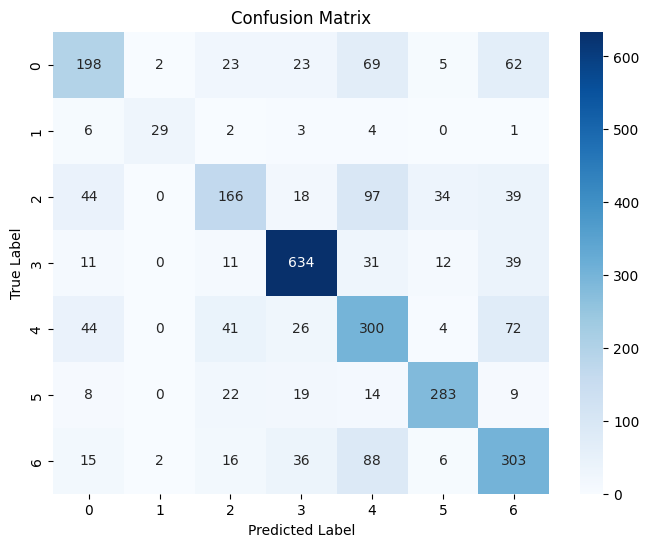

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Generate predictions
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)  # For multi-class classification
Y_true_classes = np.argmax(Y_test_oh, axis=1)  # For one-hot encoded labels

# Compute confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y_true_classes), yticklabels=np.unique(Y_true_classes))

# Add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()
